# Catcher Pitch Framing

See this paper for a "hierarchical bayesian" approach:https://arxiv.org/abs/1704.00823

See this DataRobot blog post for a ML approach (really just logistic regression): https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-1

Or, the improved DataRobot model: https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-two



In [64]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data and Model

### Statcast Data

In [2]:
# import the data for calendar year
def get_pitch_data(year):
    
    print("===================================================")
    print(f"Gathering data for {year} season")
    print("===================================================")
    print()
    
    # import the full pitch-by-pitch dataset 
    pitch_data_df = pd.read_csv(f"../data/pitch_data_{year}.csv")
    total_num_pitches = len(pitch_data_df)
    
    print(f"Number of total pitches in {year} data: {total_num_pitches}")
    print()

    # just keep the balls and called strikes
    pitch_taken = ['ball', 'called_strike']
    pitches_taken_df = pitch_data_df[pitch_data_df['description'].isin(pitch_taken)]
    num_pitches_taken = len(pitches_taken_df)

    print(f"Number of pitches taken: {num_pitches_taken}")
    print(f"Percentage of pitches taken: {round((num_pitches_taken / total_num_pitches) * 100., 2)}")
    print()

    # compute the number/percentage of taken strikes
    strikes_taken_df = pitches_taken_df[pitches_taken_df['description'] == 'called_strike']
    num_strikes_taken = len(strikes_taken_df)

    print(f"Number of strikes taken: {num_strikes_taken}")
    print(f"Percentage of pitches taken that were called strikes: {round((num_strikes_taken / num_pitches_taken) * 100., 2)}")
    print()
    
    # construct the approximate strike zone
    left_strike_boundary = -0.71
    right_strike_boundary = -left_strike_boundary

    pitches_taken_df['low_strike_boundary'] = pitches_taken_df['sz_bot']
    pitches_taken_df['high_strike_boundary'] = pitches_taken_df['sz_bot'] + pitches_taken_df['sz_top']

    bottom_strike_boundary = pitches_taken_df['low_strike_boundary'].mean()
    top_strike_boundary = pitches_taken_df['high_strike_boundary'].mean()

    print("===================================================")
    print(f"Top boundary of approximate strike zone: {round(top_strike_boundary, 2)}")
    print(f"Bottom boundary of approximate strike zone: {round(bottom_strike_boundary, 2)}")
    print(f"Right boundary of approximate strike zone: {right_strike_boundary}")
    print(f"Left boundary of approximate strike zone: {left_strike_boundary}")
    print("===================================================")
    print()
    
    # restrict ourselves to pitches that were "close enough" (i.e., within one foot of the approximate strike zone)
    pitches_taken_df = pitches_taken_df[
        (pitches_taken_df['plate_x'] >= left_strike_boundary - 1) &\
        (pitches_taken_df['plate_x'] <= right_strike_boundary + 1) &\
        (pitches_taken_df['plate_z'] <= top_strike_boundary + 1) &\
        (pitches_taken_df['plate_z'] >= bottom_strike_boundary - 1)
    ]
    num_pitches_in_zone = len(pitches_taken_df)
    
    print(f"Number of pitches within 1 foot of approximate stike zone: {num_pitches_in_zone}")
    print(f"Percentage of pitches within 1 foot of approximate strike zone: {round((num_pitches_in_zone / total_num_pitches) * 100., 2)}")
    print()
    
    # join with HP umpire dataframe (to bring in the ID of the HP umpire)
    team_rename_dict = {'NYY': 'NYA',
                        'NYM': 'NYN', 
                        'TB': 'TBA', 
                        'CHC': 'CHN',
                        'CWS': 'CHA',
                        'KC': 'KCA',
                        'SF': 'SFN',
                        'SD': 'SDN',
                        'LAD': 'LAN',
                        'LAA': 'ANA',
                        'STL': 'SLN',
                        'WSH': 'WAS'}

    def rename_team(x):
        if x in list(team_rename_dict.keys()):
            return team_rename_dict[x]
        else:
            return x
    pitches_taken_df['home_team'] = pitches_taken_df['home_team'].apply(rename_team)
    pitches_taken_df['game_team_id'] = pitches_taken_df['home_team'] + pitches_taken_df['game_date'].str.replace('-', '')
    hp_umps = pd.read_csv(f"../data/hp_umpires_{year}.csv", header=None)
    hp_umps.columns = ['game_team_id', 'hp_umpire']
    pitches_taken_df = pd.merge(pitches_taken_df, hp_umps, how='inner', on='game_team_id')
    
    # compute the unique number of umpires/batters/catchers/pitchers in the dataset
    num_unique_umpires = len(pitches_taken_df['hp_umpire'].unique())
    num_unique_batters = len(pitches_taken_df['batter'].unique())
    num_unique_catchers = len(pitches_taken_df['fielder_2'].unique())
    num_unique_pitchers = len(pitches_taken_df['pitcher'].unique())

    print(f"Number of unique umpires: {num_unique_umpires}")
    print(f"Number of unique batters: {num_unique_batters}")
    print(f"Number of unique catchers: {num_unique_catchers}")
    print(f"Number of unique pitchers: {num_unique_pitchers}")
    print()
    print()
    
    return pitches_taken_df

### Adjusting for Pitch Location

Use data from 2015-17 to estimate the pitch location function $f^u(x, z)$.

In [3]:
taken_pitches_2015_df = get_pitch_data(2015)
taken_pitches_2016_df = get_pitch_data(2016)
taken_pitches_2017_df = get_pitch_data(2017)

taken_pitches_2015_17_df = pd.concat([taken_pitches_2015_df, taken_pitches_2016_df, taken_pitches_2017_df])

print(f"Total pitches in data to estimate location function: {len(taken_pitches_2015_17_df)}")

Gathering data for 2015 season

Number of total pitches in 2015 data: 702302

Number of pitches taken: 351121
Percentage of pitches taken: 50.0

Number of strikes taken: 118692
Percentage of pitches taken that were called strikes: 33.8

Top boundary of approximate strike zone: 5.04
Bottom boundary of approximate strike zone: 1.58
Right boundary of approximate strike zone: 0.71
Left boundary of approximate strike zone: -0.71

Number of pitches within 1 foot of approximate stike zone: 309768
Percentage of pitches within 1 foot of approximate strike zone: 44.11

Number of unique umpires: 92
Number of unique batters: 952
Number of unique catchers: 110
Number of unique pitchers: 734


Gathering data for 2016 season

Number of total pitches in 2016 data: 715823

Number of pitches taken: 360212
Percentage of pitches taken: 50.32

Number of strikes taken: 120771
Percentage of pitches taken that were called strikes: 33.53

Top boundary of approximate strike zone: 5.07
Bottom boundary of approxi

#### Heat Map of Empirical Called Strike Probabilities

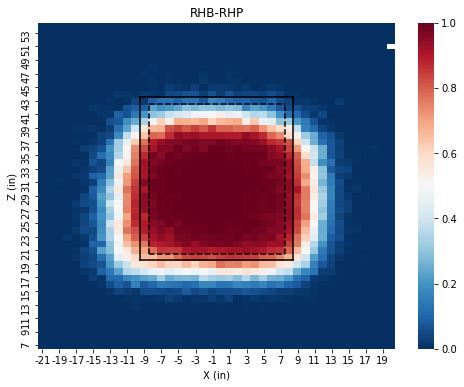

In [87]:
# just consider RH pitcher vs RH batter
batR_pitchR_df = taken_pitches_2015_17_df[(taken_pitches_2015_17_df['p_throws'] == 'R') & (taken_pitches_2015_17_df['stand'] == 'R')]

# just keep pitch outcome and plate position
cols_to_keep = ['description', 'plate_x', 'plate_z']
heat_map_df = batR_pitchR_df[cols_to_keep]

# convert to inches
heat_map_df['plate_x'] = heat_map_df['plate_x'].apply(lambda x: x * 12)
heat_map_df['plate_z'] = heat_map_df['plate_z'].apply(lambda x: x * 12)

# convert outcome to binary (1 = called strike, 0 = ball)
heat_map_df['description'] = heat_map_df['description'].apply(lambda x: 1 if x == 'called_strike' else 0)

# set limits
heat_map_df = heat_map_df[(np.abs(heat_map_df['plate_x']) <= 22) &\
                          (heat_map_df['plate_z'] <= 55) & (heat_map_df['plate_z'] >= 6)]

# for binning purposes, take the "floor" of x and z coordiates
heat_map_df['plate_x'] = np.floor(heat_map_df['plate_x']).astype(int)
heat_map_df['plate_z'] = np.floor(heat_map_df['plate_z']).astype(int)

# compute the historical strike probability (i.e., the mean) for each cell
temp_df = pd.DataFrame(heat_map_df.groupby(['plate_x', 'plate_z'])['description'].mean())
temp_df.reset_index(inplace=True, drop=False)
temp_df.columns = ['x', 'z', 'probability']

temp_df = temp_df.pivot('z', 'x', 'probability')
plt.figure(figsize=(8,6))
plt.plot([13, 29], [36, 36], '--k')
plt.plot([13, 29], [14, 14], '--k')
plt.plot([13, 13], [14, 36], '--k')
plt.plot([29, 29], [14, 36], '--k')
plt.plot([12, 30], [37, 37], '-k')
plt.plot([12, 30], [13, 13], '-k')
plt.plot([12, 12], [13, 37], '-k')
plt.plot([30, 30], [13, 37], '-k')
sns.heatmap(temp_df, cmap="RdBu_r")

plt.ylim(reversed(plt.ylim()))
plt.xlabel("X (in)")
plt.ylabel("Z (in)")
plt.title("RHB-RHP")
plt.show()

In [84]:
ax.get_xlim()

(0.0, 42.0)

In [85]:
ax.get_ylim()

(0.0, 48.0)